# **Phishing Website Detection by Machine Learning Techniques**

*Final project of Machine Learning & Cybersecurity*

# Objective
A phishing website is a common social engineering method that mimics trustful uniform resource locators (URLs) and webpages. The objective of this project is to train machine learning models on the dataset created to predict phishing websites. Both phishing and benign URLs of websites are gathered to form a dataset and from them required URL and website content-based features are extracted. The performance level of each model is measures and compared.

*This project is worked on Google Collaboratory.*<br>
*The required packages for this notebook are imported when needed.*

# Loading Data

The csv file dataset is uploaded to this notebook and stored in the pandas dataframe.

The features are extracted and stored in the dataframe. The working of this can be seen in the 'Minor Project - Phishing URL's Detection' file.

In [ ]:
# importing basic packages
import itertools
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

In [ ]:
df=pd.read_csv('/content/two.csv')

print(df.shape)
df.head()  # first five entries

(2097159, 2)


,url,type
0,drive.google.com/drive/u/0/folders/1VJ5n9lNaky...,benign
1,drive.google.com/drive/u/0/folders/1yoKq-OJhX2...,benign
2,drive.google.com/drive/u/0/folders/12xzhNeLLb-...,benign
3,en.wikipedia.org/wiki/Golden_jackal,benign
4,en.wikipedia.org/wiki/Agaricus_deserticola,benign


In [ ]:
df.type.value_counts()  # count of different types of label data

type
benign      1048583
phishing    1048576
Name: count, dtype: int64

# Plotting WordCloud

In [ ]:
df_phish = df[df.type=='phishing']
df_benign = df[df.type=='benign']

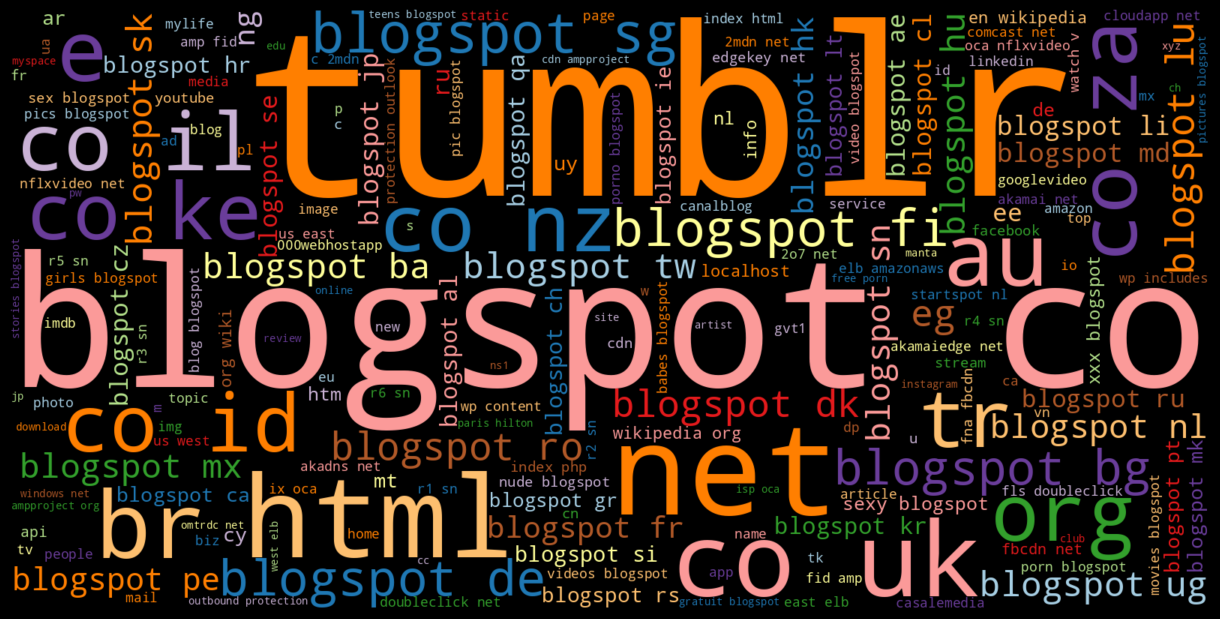

In [ ]:
# phishing
phish_url = " ".join(i for i in df_phish.url)
wordcloud = WordCloud(width=1600, height=800, colormap='Paired').generate(phish_url)
plt.figure(figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

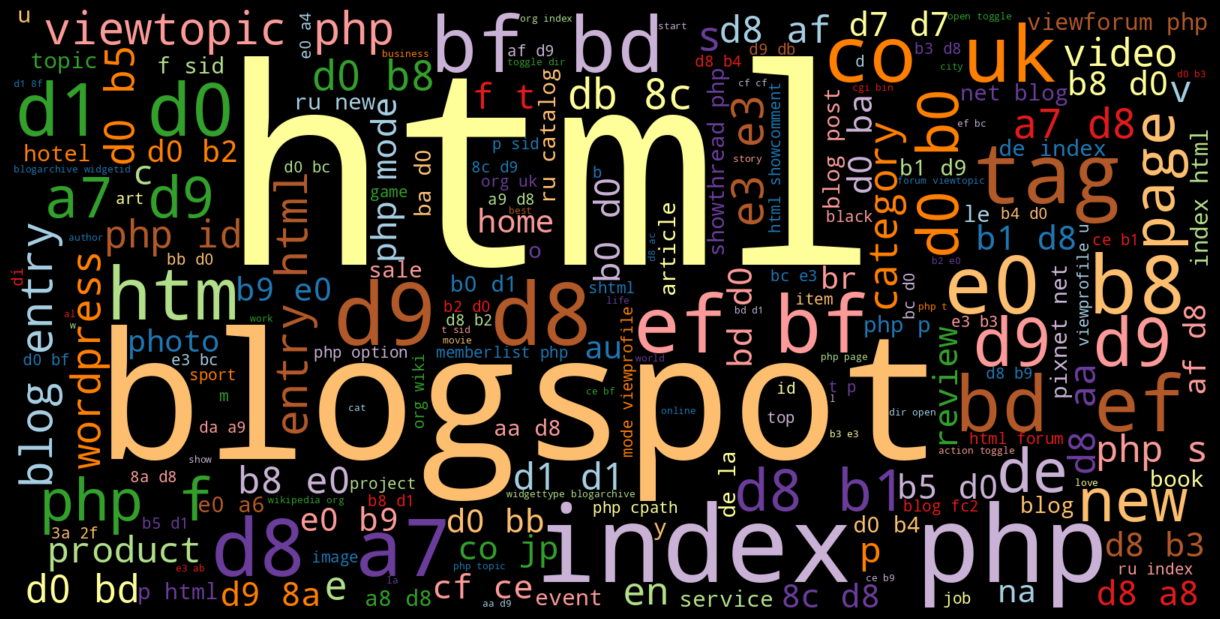

In [ ]:
# benign
benign_url = " ".join(i for i in df_benign.url)
wordcloud = WordCloud(width=1600, height=800, colormap='Paired').generate(benign_url)
plt.figure(figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Feature Engineering

In [ ]:
def get_url_length(url):  # gives the length of url
    return len(url)

# apply the get_url_length function to the dataFrame 'df' and store the result in a new column 'url_length'
df['url_length'] = df['url'].apply(get_url_length)

In [ ]:
from urllib.parse import urlparse

def get_domain_length(url):  # get domain length
    parsed_url = urlparse(url)
    domain = parsed_url.netloc  # get Domain
    domain_length = len(domain)
    return domain_length

# apply the get_domain_length function to the dataFrame 'df' and store the result in a new column 'domain_length'
df['domain_length'] = df['url'].apply(get_domain_length)

In [ ]:
import ipaddress

def is_domain_ip(url):
    try:
        parsed_url = urlparse(url)
        domain = parsed_url.netloc  # extract the domain part from the URL
        ipaddress.ip_address(domain)  # check if the domain is a valid IP address
        return 1
    except ValueError:
        return 0

# apply the is_domain_ip function to the dataFrame 'df' and store the result in a new column 'is_domain_ip'
df['is_domain_ip'] = df['url'].apply(is_domain_ip)

In [ ]:
!pip install tld  # to get the top level domain

from tld import get_tld

def tld_length(tld):  # to get the tld length
    if tld:
        return len(tld)
    else:
        return -1

df['tld'] = df['url'].apply(lambda i: get_tld(i, fail_silently=True))
df['tld_length'] = df['tld'].apply(tld_length)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 2.6 MB/s eta 0:00:00


In [ ]:
def char_continuation_rate(url):  # to get character continuation rate in URL
    continuous_count = 0
    total_count = len(url)

    for i in range(1, len(url)):
        if url[i] == url[i - 1]:
            continuous_count += 1

    if total_count > 0:
        continuation_rate = continuous_count / total_count
    else:
        continuation_rate = 0.0

    return continuation_rate

df['char_continuation_rate'] = df['url'].apply(char_continuation_rate)

In [ ]:
def url_character_prob(url):  # to get the probability of a character
    char_count = {}
    total_chars = len(url)

    for char in url:
        char_count[char] = char_count.get(char, 0) + 1

    char_prob = {char: count / total_chars for char, count in char_count.items()}

    # calculate the mean probability
    mean_prob = sum(char_prob.values()) / len(char_prob)

    return mean_prob

df['URLCharProb'] = df['url'].apply(url_character_prob)

In [ ]:
def number_of_subdomains(url):
    parsed_url = urlparse(url)
    domain = parsed_url.netloc

    if domain:
        num_subdomains = domain.count('.')
    else:
        num_subdomains = 0

    return num_subdomains

df['NoOfSubDomain'] = df['url'].apply(number_of_subdomains)

In [ ]:
def has_obfuscation(url):
    # list of common obfuscation patterns to detect
    obfuscation_patterns = [
        '%',                     # Percentage encoding
        '\\x',                   # Hexadecimal encoding
        '&#',                    # HTML entity encoding
        '\\u',                   # Unicode encoding (corrected)
        'javascript:',           # JavaScript code injection
        'data:',                 # Data URL scheme
        'blob:',                 # Blob URL scheme
        'onerror', 'onload',     # Event handlers
        'document.cookie',       # Access to cookies
        'eval(', 'exec(',        # Evaluation functions
        'unescape(',             # Unescaping
        'String.fromCharCode(',  # Constructing strings
        'String.fromCodePoint(', # Constructing strings
        'String.raw(',           # Constructing strings
    ]

    # check if any obfuscation pattern is found in the URL
    for pattern in obfuscation_patterns:
        if pattern in url.lower():
            return 1  # obfuscation detected

    return 0  # no obfuscation detected

# apply the has_obfuscation function to the dataFrame 'df' and store the result in a new column 'HasObfuscation'
df['HasObfuscation'] = df['url'].apply(has_obfuscation)

In [ ]:
def number_of_obfuscated_chars(url):
    # list of common obfuscation patterns to detect
    obfuscation_patterns = [
        '%',     # Percentage encoding
        '&#',    # HTML entity encoding
        '\\u',   # Unicode encoding
        '\\x',   # Hexadecimal encoding
        '\u202E', '\u200E', '\u200F', '\u202A', '\u202B', '\u202C'  # Directional formatting characters
    ]

    # initialize the counter for obfuscated characters
    num_obfuscated_chars = 0

    # check for each obfuscation pattern in the URL
    for pattern in obfuscation_patterns:
        # count the occurrences of the obfuscation pattern in the URL
        num_obfuscated_chars += url.lower().count(pattern)

    return num_obfuscated_chars

# apply the number_of_obfuscated_chars function to the dataFrame 'df' and store the result in a new column 'NoOfObfuscatedChar'
df['NoOfObfuscatedChar'] = df['url'].apply(number_of_obfuscated_chars)


In [ ]:
def obfuscation_ratio(url):
    # list of common obfuscation patterns to detect
    obfuscation_patterns = [
        '%',     # Percentage encoding
        '&#',    # HTML entity encoding
        '\\u',   # Unicode encoding
        '\\x',   # Hexadecimal encoding
        '\u202E', '\u200E', '\u200F', '\u202A', '\u202B', '\u202C'  # Directional formatting characters
    ]

    # count the total number of characters in the URL
    total_chars = len(url)

    # initialize the counter for obfuscated characters
    num_obfuscated_chars = 0

    # check for each obfuscation pattern in the URL
    for pattern in obfuscation_patterns:
        # count the occurrences of the obfuscation pattern in the URL
        num_obfuscated_chars += url.lower().count(pattern)

    # calculate the obfuscation ratio
    obfuscation_ratio = num_obfuscated_chars / total_chars if total_chars > 0 else 0.0

    return obfuscation_ratio

# apply the obfuscation_ratio function to the DataFrame 'df' and store the result in a new column 'ObfuscationRatio'
df['ObfuscationRatio'] = df['url'].apply(obfuscation_ratio)

In [ ]:
def number_of_letters_in_url(url):
    letters = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

    num_letters = sum(url.count(letter) for letter in letters)

    return num_letters

df['NoOfLettersInURL'] = df['url'].apply(number_of_letters_in_url)

In [ ]:
def letter_ratio_in_url(url):
    num_letters = number_of_letters_in_url(url)

    total_chars = len(url)

    if total_chars > 0:
        letter_ratio = num_letters / total_chars
    else:
        letter_ratio = 0.0

    return letter_ratio

df['LetterRatioInURL'] = df['url'].apply(letter_ratio_in_url)

In [ ]:
def number_of_digits_in_url(url):
    digits = '0123456789'

    num_digits = sum(url.count(digit) for digit in digits)

    return num_digits

df['NoOfDigitsInURL'] = df['url'].apply(number_of_digits_in_url)

In [ ]:
def digit_ratio_in_url(url):
    num_digits = number_of_digits_in_url(url)

    total_chars = len(url)

    if total_chars > 0:
        digit_ratio = num_digits / total_chars
    else:
        digit_ratio = 0.0

    return digit_ratio

df['DigitRatioInURL'] = df['url'].apply(digit_ratio_in_url)

In [ ]:
def number_of_ampersand_in_url(url):
    num_ampersand = url.count('&')

    return num_ampersand

df['NoOfAmpersandInURL'] = df['url'].apply(number_of_ampersand_in_url)

In [ ]:
def number_of_other_special_chars_in_url(url):
    allowed_chars = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789./:?&=%'

    num_other_special_chars = sum(1 for char in url if char not in allowed_chars)

    return num_other_special_chars

df['NoOfOtherSpecialCharsInURL'] = df['url'].apply(number_of_other_special_chars_in_url)

In [ ]:
def special_char_ratio_in_url(url):
    num_special_chars = number_of_other_special_chars_in_url(url)

    total_chars = len(url)

    if total_chars > 0:
        special_char_ratio = num_special_chars / total_chars
    else:
        special_char_ratio = 0.0

    return special_char_ratio

df['SpecialCharRatioInURL'] = df['url'].apply(special_char_ratio_in_url)

In [ ]:
def is_https(url):
    # check if the URL starts with "https://"
    if url.startswith("https://"):
        return 1
    else:
        return 0

df['IsHTTPS'] = df['url'].apply(is_https)

In [ ]:
def calculate_tld_legitimate_prop(url):
    try:
        # get the Top-Level Domain (TLD) from the URL
        tld = get_tld(url, fail_silently=True)

        # list of commonly recognized TLDs used by legitimate websites
        legitimate_tlds = ['com', 'net', 'org', 'edu', 'gov']

        # check if the extracted TLD is in the list of legitimate TLDs
        if tld in legitimate_tlds:
            return 1.0  # TLD is considered legitimate
        else:
            return 0.0  # TLD is not considered legitimate
    except:
        return -1  # Error: Unable to extract TLD

# apply the calculate_tld_legitimate_prop function to the DataFrame 'df' and store the result in a new column 'TLDLegitimateProp'
df['TLDLegitimateProp'] = df['url'].apply(calculate_tld_legitimate_prop)

In [ ]:
import re
# use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))

In [ ]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        return 1
    else:
        return 0

df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

In [ ]:
def count_per(url):
    return url.count('%')

df['count%'] = df['url'].apply(lambda i : count_per(i))

In [ ]:
def count_ques(url):
    return url.count('?')

df['count?'] = df['url'].apply(lambda i: count_ques(i))

In [ ]:
def count_hyphen(url):
    return url.count('-')

df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

In [ ]:
def count_equal(url):
    return url.count('=')

df['count='] = df['url'].apply(lambda i: count_equal(i))

In [ ]:
def count_www(url):
  url.count('www')
  return url.count('www')

df['count-www'] = df['url'].apply(lambda i: count_www(i))

In [ ]:
def count_atrate(url):
  return url.count('@')

df['count@'] = df['url'].apply(lambda i: count_atrate(i))

In [ ]:
def no_of_dir(url):
  urldir = urlparse(url).path
  return urldir.count('/')

df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

In [ ]:
def no_of_embed(url):
  urldir = urlparse(url).path
  return urldir.count('//')

df['count_embed_domain'] = df['url'].apply(lambda i: no_of_embed(i))

In [ ]:
def count_https(url):
    return url.count('https')

df['count-https'] = df['url'].apply(lambda i : count_https(i))

In [ ]:
def count_http(url):
    return url.count('http')

df['count-http'] = df['url'].apply(lambda i : count_http(i))

In [ ]:
def count_dot(url):
  count_dot = url.count('.')
  return count_dot

df['count.'] = df['url'].apply(lambda i: count_dot(i))

In [ ]:
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

In [ ]:
def hostname_length(url):
    return len(urlparse(url).netloc)

df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))

In [ ]:
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0

df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))

In [ ]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

df['count-digits']= df['url'].apply(lambda i: digit_count(i))

In [ ]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

df['count-letters']= df['url'].apply(lambda i: letter_count(i))

In [ ]:
!pip install googlesearch-python

from googlesearch import search

def google_index(url):
  site = search(url, 5)
  return 1 if site else 0

df['google_index'] = df['url'].apply(lambda i: google_index(i))

  Preparing metadata (setup.py) ... done
  Created wheel for googlesearch-python: filename=googlesearch_python-1.2.3-py3-none-any.whl size=4205 sha256=0d41aecad1899e7957201772cde2b11b33d744d77f5a7f8bf1028f88d6bd8ab7
  Stored in directory: /root/.cache/pip/wheels/98/24/e9/6c225502948c629b01cc895f86406819281ef0da385f3eb669
Successfully built googlesearch-python


In [ ]:
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

In [ ]:
df.columns

Index(['url', 'type', 'url_length', 'domain_length', 'is_domain_ip', 'tld',
       'tld_length', 'char_continuation_rate', 'URLCharProb', 'NoOfSubDomain',
       'HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio',
       'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDigitsInURL',
       'DigitRatioInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL',
       'SpecialCharRatioInURL', 'IsHTTPS', 'TLDLegitimateProp', 'use_of_ip',
       'abnormal_url', 'count%', 'count?', 'count-', 'count=', 'count-www',
       'count@', 'count_dir', 'count_embed_domain', 'count-https',
       'count-http', 'count.', 'short_url', 'hostname_length', 'sus_url',
       'count-digits', 'count-letters', 'google_index', 'fd_length'],
      dtype='object')

# Target Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])
df["type_code"].value_counts()

type_code
0    1048583
1    1048576
Name: count, dtype: int64

# Creation of Predictor and Target Variables

In [ ]:
#Predictor Variables
X = df[['url_length','domain_length', 'is_domain_ip', 'tld_length', 'char_continuation_rate', 'URLCharProb', 'NoOfSubDomain',
       'HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio',
       'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDigitsInURL',
       'DigitRatioInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL',
       'SpecialCharRatioInURL', 'IsHTTPS', 'TLDLegitimateProp', 'use_of_ip',
       'abnormal_url', 'count%', 'count?', 'count-', 'count=', 'count-www',
       'count@', 'count_dir', 'count_embed_domain', 'count-https', 'count.',
       'count-http', 'short_url', 'hostname_length', 'sus_url', 'count-digits',
       'count-letters', 'google_index', 'fd_length']]

#Target Variable
Y = df['type_code']

In [ ]:
X.head()

,domain_length,is_domain_ip,tld_length,char_continuation_rate,URLCharProb,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,ObfuscationRatio,NoOfLettersInURL,...,count-https,count.,count-http,short_url,hostname_length,sus_url,count-digits,count-letters,google_index,fd_length
0,0,0,-1,0.014706,0.026316,0,0,0,0.0,54,...,0,2,0,0,0,0,6,54,1,5
1,0,0,-1,0.014706,0.025641,0,0,0,0.0,54,...,0,2,0,0,0,0,6,54,1,5
2,0,0,-1,0.029412,0.027778,0,0,0,0.0,55,...,0,2,0,0,0,0,5,55,1,5
3,0,0,-1,0.000000,0.055556,0,0,0,0.0,30,...,0,2,0,0,0,0,0,30,1,4
4,0,0,-1,0.000000,0.050000,0,0,0,0.0,37,...,0,2,0,0,0,0,0,37,1,4


In [ ]:
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: type_code, dtype: int64

# Train Test Split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, shuffle=True, random_state=5)

# Model Building - Random Forest Classifier

In [ ]:
import sklearn.metrics as metrics

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100,max_features='sqrt')
rf.fit(X_train,Y_train)
Y_pred_rf = rf.predict(X_test)
print(classification_report(Y_test,Y_pred_rf,target_names=['benign','phishing']))
score = metrics.accuracy_score(Y_test, Y_pred_rf)
print("accuracy: %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.94      0.98      0.96    209717
    phishing       0.98      0.94      0.96    209715

    accuracy                           0.96    419432
   macro avg       0.96      0.96      0.96    419432
weighted avg       0.96      0.96      0.96    419432

accuracy: 0.957


In [ ]:
# accuracy score on training data
X_train_prediction = rf.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)
print('Accuracy score of the training data : ', training_data_accuracy)

# accuracy score on testing data
X_test_prediction = rf.predict(X_test)
testing_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy score of the testing data : ', testing_data_accuracy)

Accuracy score of the training data :  0.9915731224448316
Accuracy score of the testing data :  0.9572993953727899


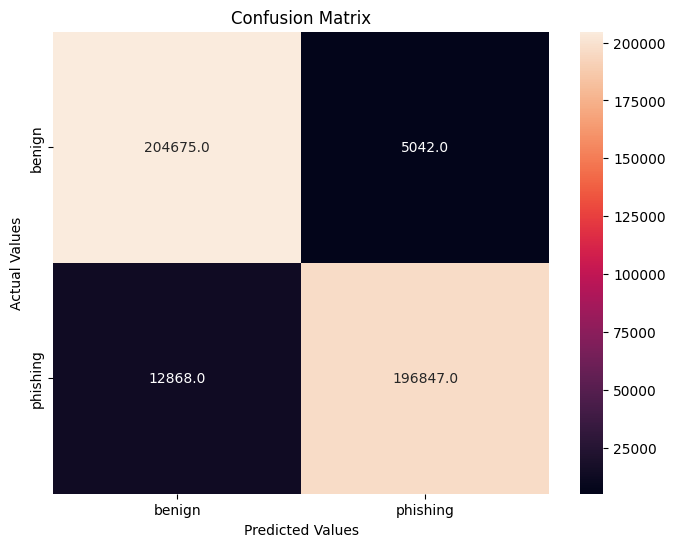

In [ ]:
# confusion matrix
cm = confusion_matrix(Y_test, Y_pred_rf)
cm_df = pd.DataFrame(cm, index = ['benign', 'phishing'], columns = ['benign', 'phishing'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

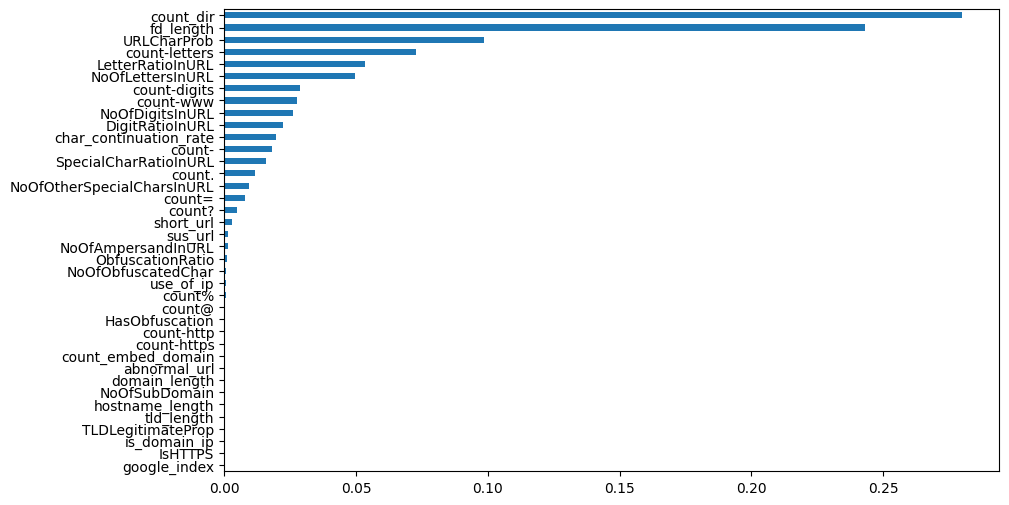

In [ ]:
# feature importance
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

# Prediction

In [ ]:
def main(url):

    status = []

    status.append(get_url_length(url))
    status.append(get_domain_length(url))
    status.append(is_domain_ip(url))
    tld = get_tld(url,fail_silently=True)
    status.append(tld_length(tld))
    status.append(char_continuation_rate(url))
    status.append(url_character_prob(url))
    status.append(number_of_subdomains(url))
    status.append(has_obfuscation(url))
    status.append(number_of_obfuscated_chars(url))
    status.append(obfuscation_ratio(url))
    status.append(number_of_letters_in_url(url))
    status.append(letter_ratio_in_url(url))
    status.append(number_of_digits_in_url(url))
    status.append(digit_ratio_in_url(url))
    status.append(number_of_ampersand_in_url(url))
    status.append(number_of_other_special_chars_in_url(url))
    status.append(special_char_ratio_in_url(url))
    status.append(is_https(url))
    status.append(calculate_tld_legitimate_prop(url))
    status.append(having_ip_address(url))
    status.append(abnormal_url(url))
    status.append(count_per(url))
    status.append(count_ques(url))
    status.append(count_hyphen(url))
    status.append(count_equal(url))
    status.append(count_www(url))
    status.append(count_atrate(url))
    status.append(no_of_dir(url))
    status.append(no_of_embed(url))
    status.append(count_https(url))
    status.append(count_dot(url))
    status.append(count_http(url))
    status.append(shortening_service(url))
    status.append(hostname_length(url))
    status.append(suspicious_words(url))
    status.append(digit_count(url))
    status.append(letter_count(url))
    status.append(google_index(url))
    status.append(fd_length(url))

    return status

# predict function
def get_prediction_from_url(test_url):
    features_test = main(test_url)

    # due to updates to scikit-learn, we now need a 2D array as a parameter to the predict function.
    features_test = np.array(features_test).reshape((1, -1))

    pred = rf.predict(features_test)

    if int(pred[0]) == 0:
        res="SAFE"
        return res

    elif int(pred[0]) == 1.0:
        res="PHISHING"
        return res

# predicting sample raw URLs
urls = ['https://drive.google.com/drive/','https://titaniumcorporate.co.za','http://digitalsuporte24hrsonline.shop/renner/','https://jeffwealth.com/index/login/login/token/dc737dfb0b882535dff63a086740c6d8.html','https://lmezyera.duckdns.org','https://en.wikipedia.org/wiki/North_Dakota','https://www.google.com/','https://www.upgradabroad.com/','https://www.tcs.com/']

for url in urls:
     print(get_prediction_from_url(url))

SAFE
PHISHING
PHISHING
PHISHING
PHISHING
SAFE
SAFE
SAFE
SAFE


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X

# Saving the trained model

In [ ]:
import pickle

filename = 'trained_model.sav'
pickle.dump(rf, open(filename, 'wb'))

# pickle_out = open("trained_model.pkl","wb")
# pickle.dump(rf, pickle_out)
# pickle_out.close()

# Loading the saved model

In [ ]:
loaded_model = pickle.load(open('trained_model.sav', 'rb'))

# predict function
def get_prediction_from_url_in_model(test_url):
    features_test = main(test_url)

    # Due to updates to scikit-learn, we now need a 2D array as a parameter to the predict function.
    features_test = np.array(features_test).reshape((1, -1))

    pred = loaded_model.predict(features_test)

    if int(pred[0]) == 0:
        res="SAFE"
        return res

    elif int(pred[0]) == 1.0:
        res="PHISHING"
        return res

# predicting sample raw URLs
urls = ['titaniumcorporate.co.za','https://en.wikipedia.org/wiki/North_Dakota','https://baseball-reference.com/players/h/harrige01.shtml','https://www.google.com/']

for url in urls:
     print(get_prediction_from_url_in_model(url))

PHISHING
SAFE
SAFE
SAFE


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


# References

* https://blog.keras.io/building-autoencoders-in-keras.html
* https://en.wikipedia.org/wiki/Autoencoder
* https://mc.ai/a-beginners-guide-to-build-stacked-autoencoder-and-tying-weights-with-it/
* https://github.com/shreyagopal/t81_558_deep_learning/blob/master/t81_558_class_14_03_anomaly.ipynb
* https://machinelearningmastery.com/save-gradient-boosting-models-xgboost-python/

